In [51]:
import numpy as np
import math
import matplotlib.ticker as ticker


def make_parity_plot_colorful(data, data_description, ax, plot_lim='largest_kgh'):
    """
    :param data: processed data to be plotted
    :param data_description: dictionary with descriptions of data used for plot annotations
    :param ax: subplot ax to plot on
    :param plot_lim: limit of x and y axes
    :return: ax: is the plotted parity chart
    """

    # Stage key for blinded status
    stage_description = {
        1: 'Fully blinded results',
        2: 'Unblinded wind',
        3: 'Partially unblinded',
    }
    ############ Data Preparation and Linear Regression ############

    # Load data description
    operator = data_description['operator']
    stage = data_description['stage']
    time_ave = data_description['time_ave']
    gas_comp_source = data_description['gas_comp_source']
    strict_discard = data_description['strict_discard']
    # legend_error = data_description['legend_error']

    # all data for linear regression 
    x_data = data.release_rate
    y_data = data.operator_report
    x_error = data.release_sigma * 1.96  # value is sigma, multiply by 1.96 for 95% CI
    y_error = data.operator_sigma  # error bars are determined in get_parity_data function

    # Fit linear regression via least squares with numpy.polyfit
    # m is slope, intercept is b
    m, b = np.polyfit(x_data, y_data, deg=1)

    # Calculate R^2 value
    # (using method described here: https://www.askpython.com/python/coefficient-of-determination)
    correlation_matrix = np.corrcoef(x_data, y_data)
    correlation = correlation_matrix[0, 1]
    r2 = correlation ** 2

    # Number of valid overpasses:
    sample_size = len(y_data)

    # Set x and y max values
    # Manually set largest x and y value by changing largest_kgh here to desired value:
    # largest_kgh = max(plot_lim)

    if plot_lim == 'largest_kgh':
        # Filter out NA because operations with NA returns NA
        if np.isnan(max(y_error)) == 1:
            y_error.iloc[:] = 0

        largest_kgh = max(max(x_data), max(y_data)) + max(y_error)
        largest_kgh = math.ceil(largest_kgh / 100) * 100

        # set plot_lim:
        plot_lim = [0, largest_kgh]
    else:
        largest_kgh = max(plot_lim)

    # Create sequence of numbers for plotting linear fit (x)
    x_seq = np.linspace(0, largest_kgh, num=100)

    ############ Generate Figure  ############

    # Add linear regression to in put ax
    ax.plot(x_seq, m * x_seq + b, color='k', lw=2,
            label=f'Best Fit, $R^2 =$ {r2:0.2f}\n$y = {m:0.2f}x+{b:0.2f}$',
            )

    # Add parity line
    # With label:
    # ax.plot(x_seq, x_seq, color='k', lw=2, linestyle='--',
    #          label='Parity Line')
    # Without label:
    ax.plot(x_seq, x_seq, color='k', lw=2, linestyle='--')
    
    # Make datasets for the blinded and unblinded data 
    
    # Break out data that was blinded vs unblinded in Phase III 
    data_unblinded = data[data['phase_iii'] == 1]
    data_blinded = data[data['phase_iii'] == 0]
    
    # Unblinded data in Phase III (ie excluded from Phase III) 
    x_data_unblinded = data_unblinded.release_rate
    y_data_unblinded = data_unblinded.operator_report
    x_error_unblinded = data_unblinded.release_sigma * 1.96  # value is sigma, multiply by 1.96 for 95% CI
    y_error_unblinded = data_unblinded.operator_sigma  # error bars are determined in get_parity_data function
    
    # Blinded data in Phase III (ie excluded from Phase III) 
    x_data_blinded = data_blinded.release_rate
    y_data_blinded = data_blinded.operator_report
    x_error_blinded = data_blinded.release_sigma * 1.96  # value is sigma, multiply by 1.96 for 95% CI
    y_error_blinded = data_blinded.operator_sigma  # error bars are determined in get_parity_data function

    # Unblinded data: add scatter plots with error bars
    
    # unblined sample size: 
    unblinded_sample_size = len(y_data_unblinded)
    unblinded_color = '#ff7f0e'
    ax.errorbar(x_data_unblinded, y_data_unblinded,
                xerr=x_error_unblinded,
                yerr=y_error_unblinded,
                linestyle='none',
                mfc='white',
                label=f'n = {unblinded_sample_size} (unblinded in Stage 3)',
                fmt='o',
                markersize=5, 
                color=unblinded_color,
                ecolor=unblinded_color)
    
    # Blinded data: add scatter plots with error bars
    blinded_sample_size = len(y_data_blinded)
    blinded_color = '#1f77b4'
    ax.errorbar(x_data_blinded, y_data_blinded,
                xerr=x_error_blinded,
                yerr=y_error_blinded,
                linestyle='none',
                mfc='white',
                color=blinded_color,
                label=f'n = {blinded_sample_size} (blinded in Stage 3)',
                fmt='o',
                markersize=5,
                ecolor=blinded_color)

    stage_text = stage_description[stage]
    # Set title
    ax.set_title(f'{operator} ({stage_text})')

    # ax.text(100, largest_kgh-100, f'{operator} ({stage_text})', fontsize=15, horizontalalignment='left',
    #          bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

    # Annotation box
    # text = f'{operator}\n {stage_text}'
    # ob = offsetbox.AnchoredText(text, loc='upper left')
    # ob.set(alpha=0.8)
    # ax.add_artist(ob)

    # Set axes
    ax.set(xlim=plot_lim,
           ylim=plot_lim,
           alpha=0.8)

    # Equalize Axes
    ax.set_aspect('equal', adjustable='box')

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Axes labels
    # ax.set_xlabel('Methane Release Rate (kgh)', fontsize=14)
    # ax.set_ylabel('Reported Release Rate (kgh)', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=16)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=True, top=True, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)
    ax.grid(False)  # remove grid lines

    # Customize the tick labels with commas at the thousands place
    ax.tick_params(labelsize=16)

    # Define a formatter function to add commas
    def comma_formatter(x, pos):
        return '{:,.0f}'.format(x)  # Add commas to the thousands place

    # Apply the formatter to the tick labels
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))

    # Legend
    ax.legend(facecolor='white', loc='lower right', fontsize=11)

    return ax


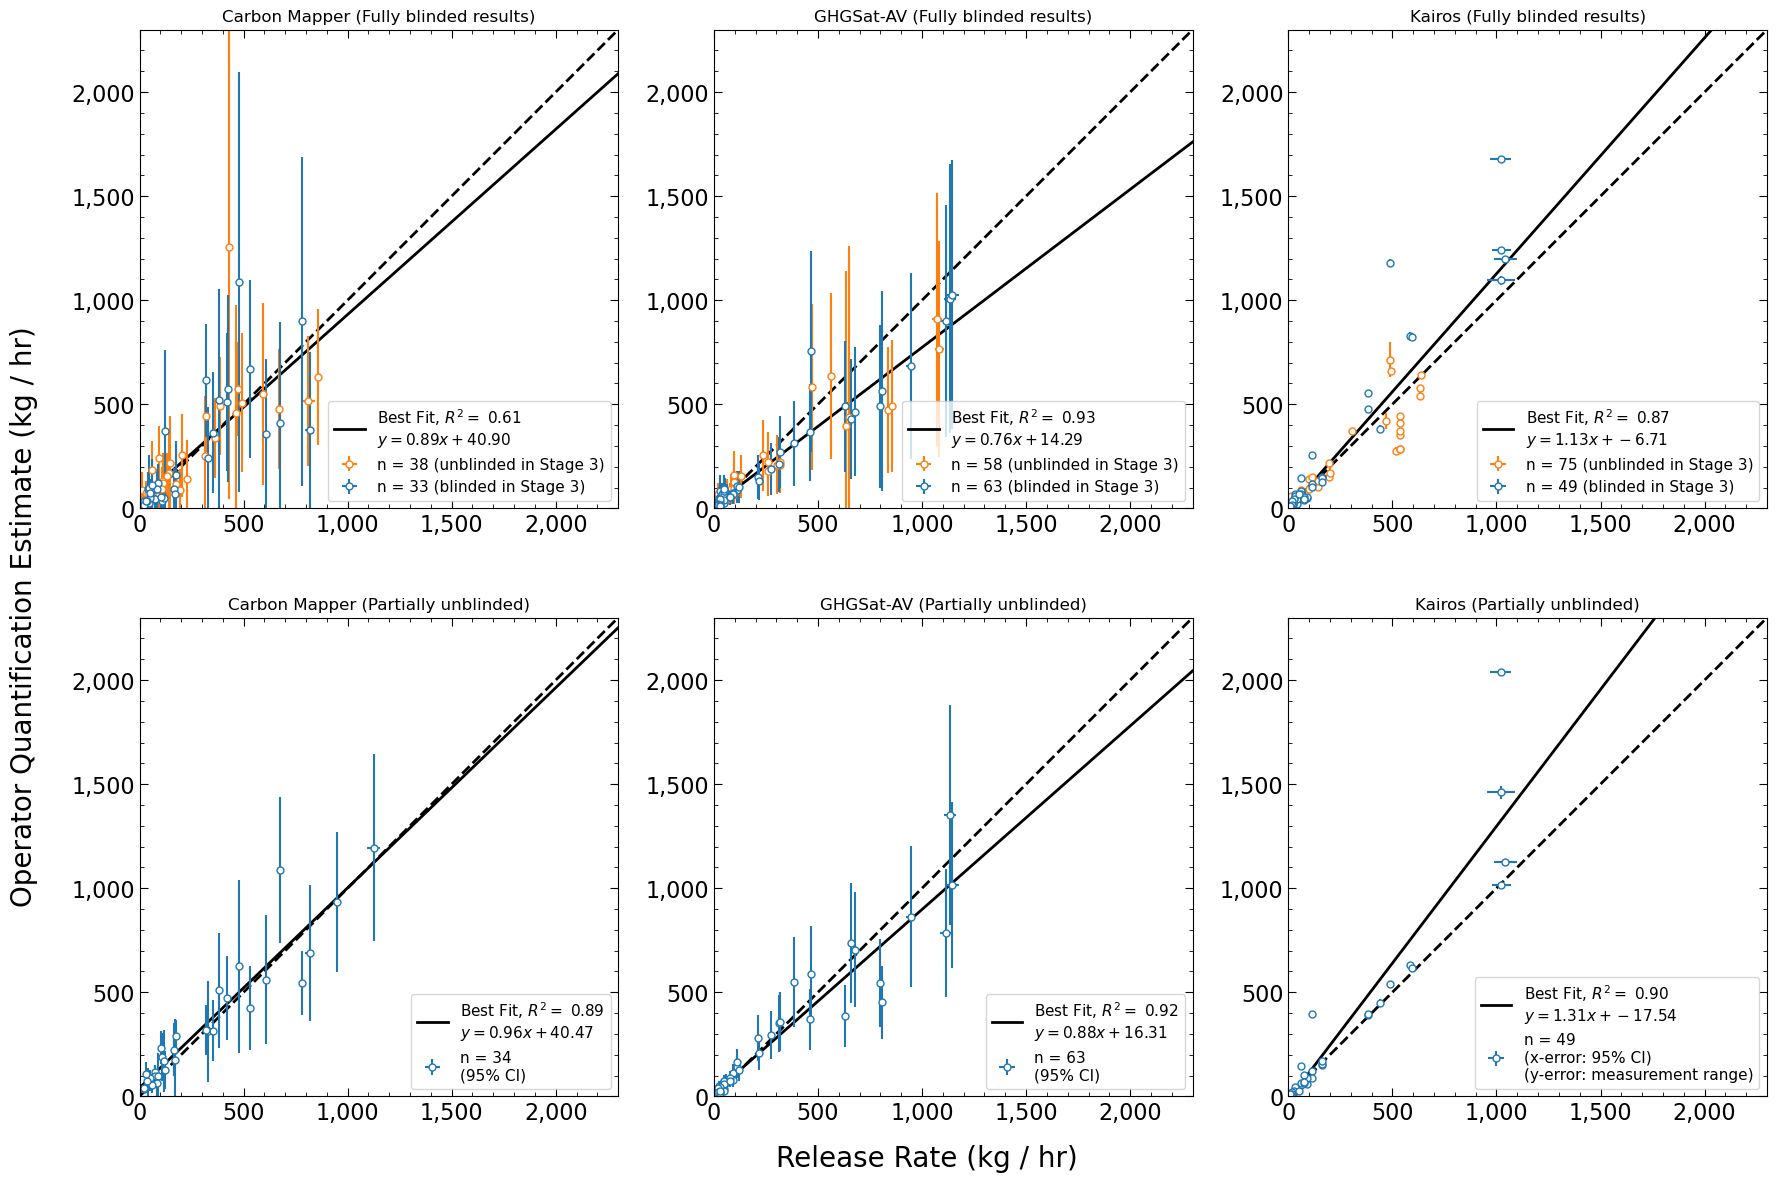

In [63]:
import pathlib

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from plot_methods import get_parity_data, make_parity_plot

#Phase 1 data 
cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat-AV', stage = 1)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage = 1)

# Phase 3 data
cm_3_data, cm_3_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat-AV', stage = 3)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)


axes_max = 2300

# # Set up figure - use smaller grid for now 
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6]] = plt.subplots(2,3, figsize=[21,14])
# 

# Phase 1 data
ax1 = make_parity_plot_colorful(cm_1_data, cm_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot_colorful(ghg_1_data, ghg_1_notes, ax2, [0, axes_max])
ax3 = make_parity_plot_colorful(kairos_1_data, kairos_1_notes, ax3, [0, axes_max])

# Phase 3 data 
ax4 = make_parity_plot(cm_3_data, cm_3_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(ghg_3_data, ghg_3_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(kairos_3_data, kairos_3_notes, ax6, [0, axes_max])

# Add common x-axis
txt_x_label = fig.text(0.5, 0.06, 'Release Rate (kg / hr)', ha='center', va='bottom', fontsize=20)

# Add common y-axis
txt_y_label_left = fig.text(0.07, 0.25, 'Operator Quantification Estimate (kg / hr)', rotation = 'vertical', ha='center', va='bottom', fontsize=20)



save_path = pathlib.PurePath('04_figures', '02_sahar_peer_review', f'test_plot_colors_phase1_3')
plt.savefig(save_path)
# display(cm_1_data_phase3_blind)

Making GHGSat plots...
Making Kairos plots...
Making MethaneAIR plots...
Figure saved


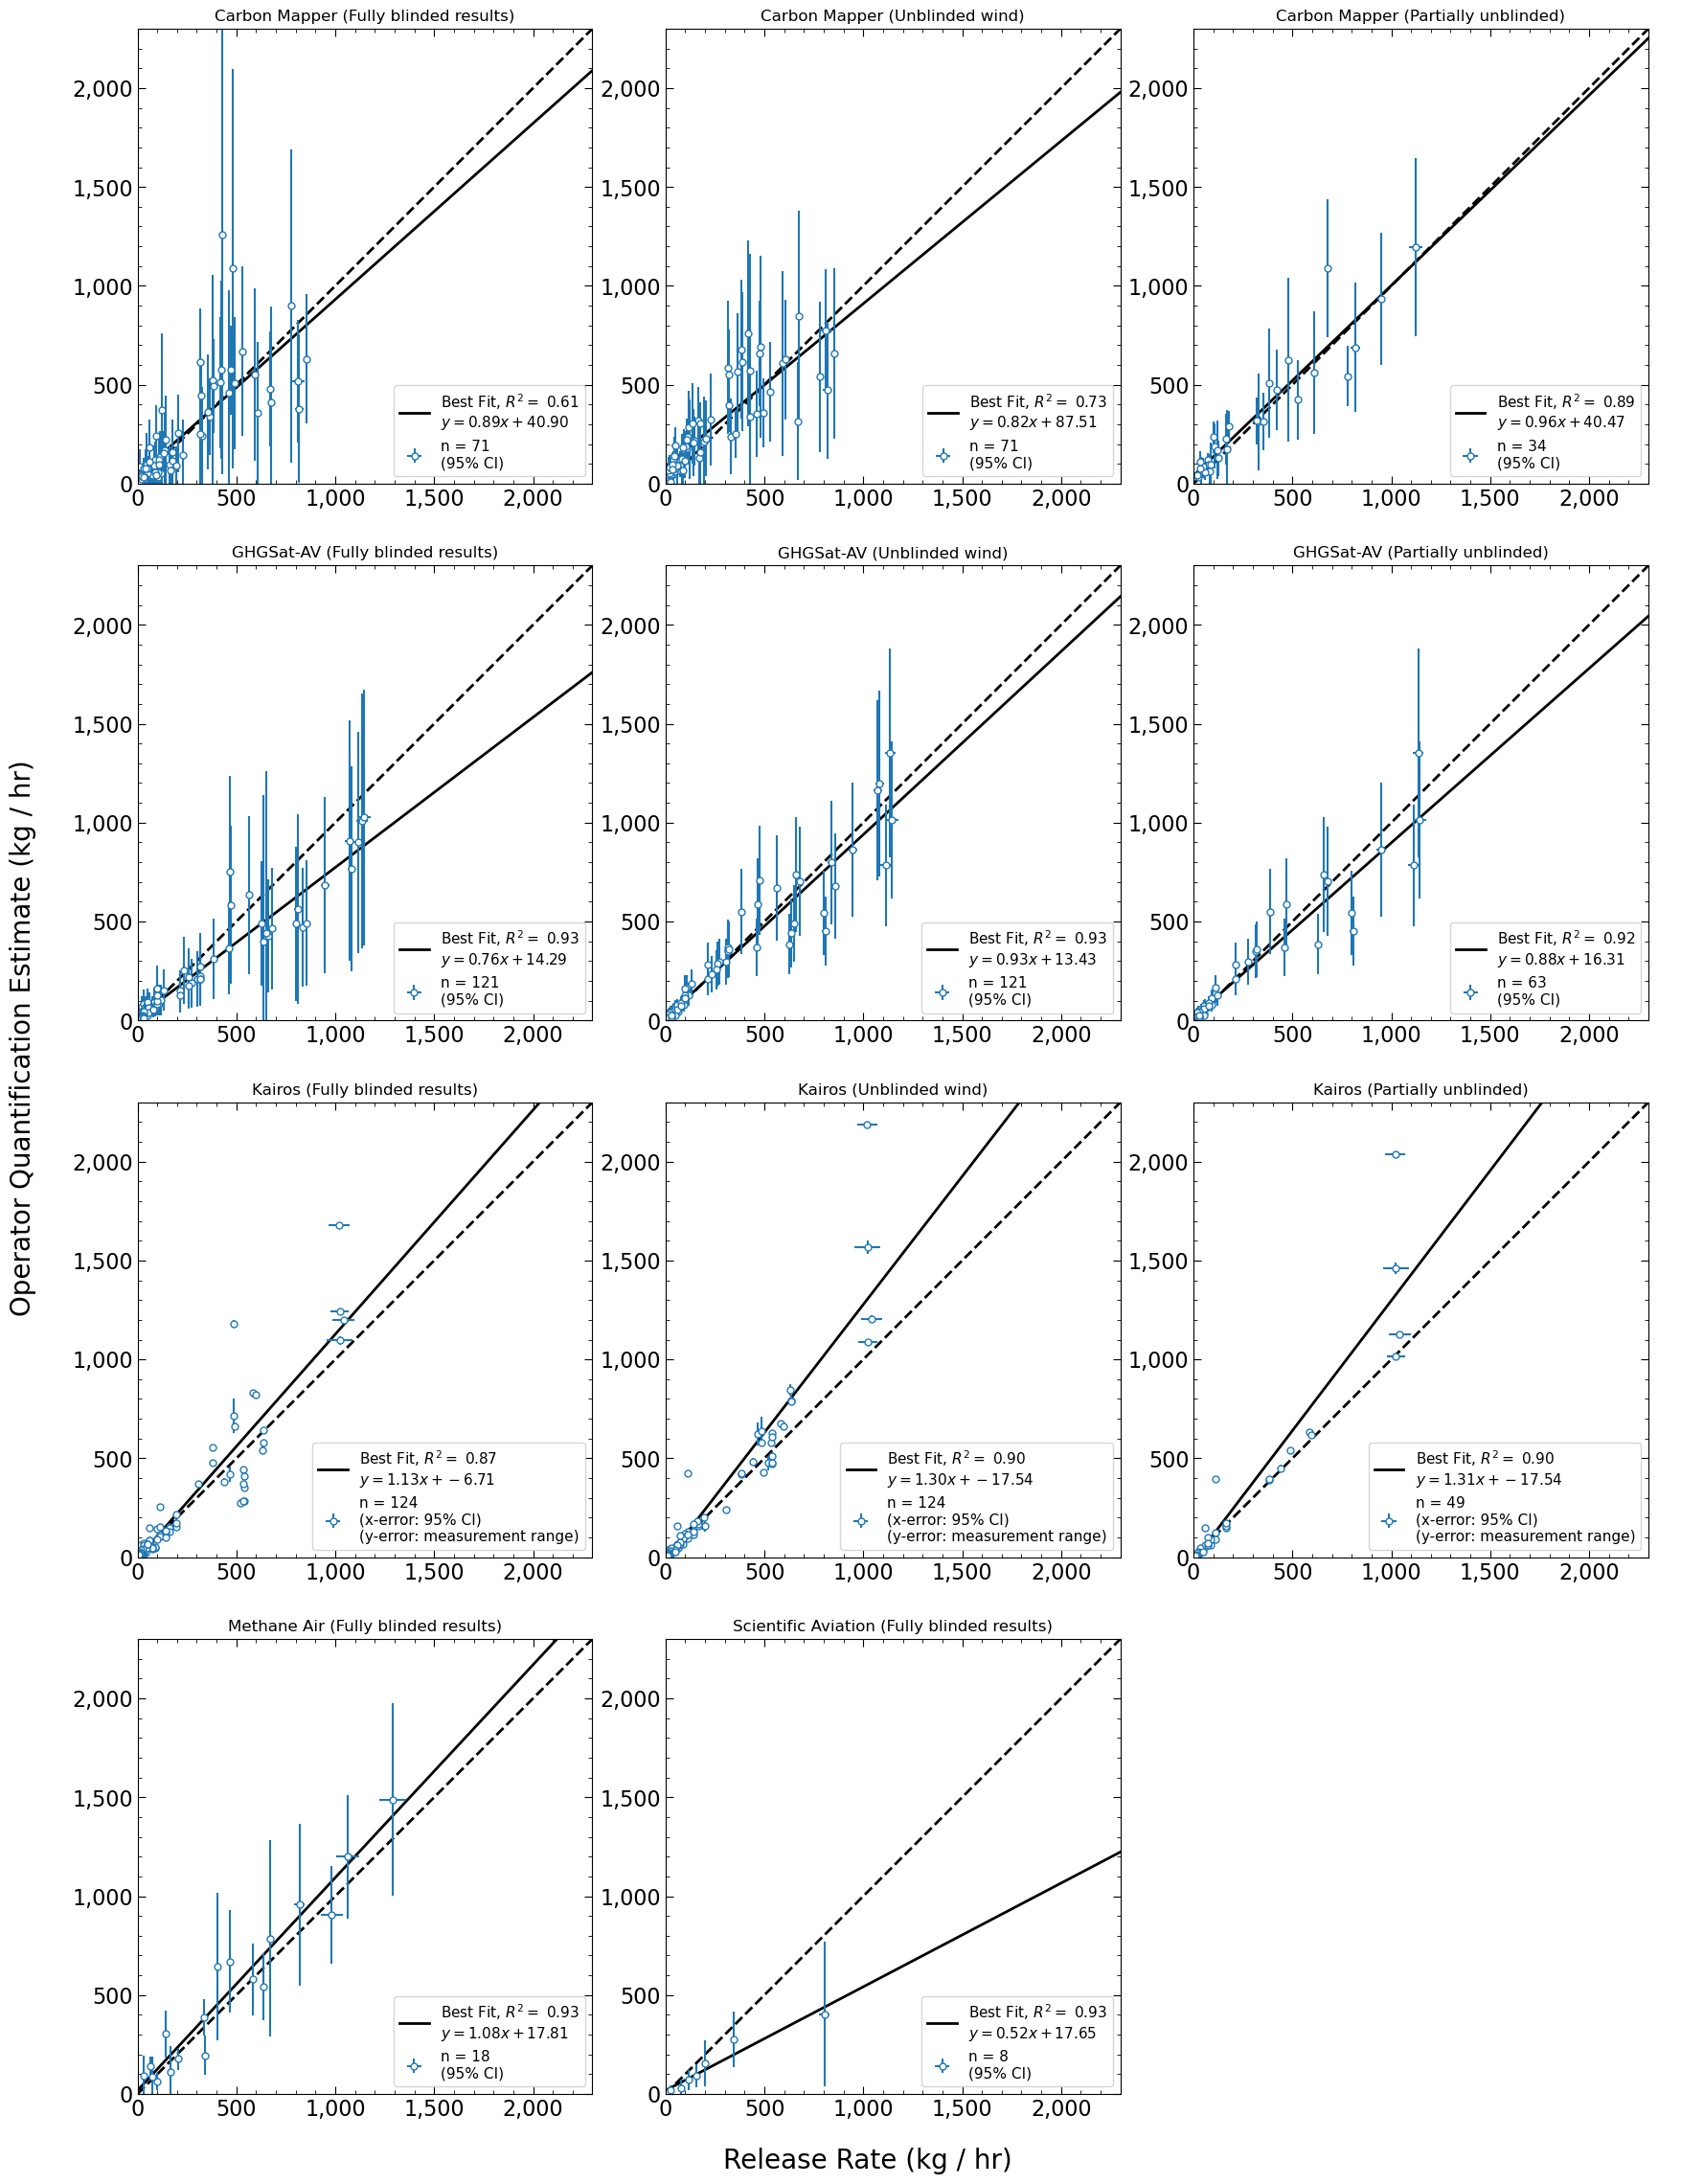

In [53]:
# This is the code I copied from 11_paper_figures.ipynb 

import pathlib

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from plot_methods import get_parity_data, make_parity_plot

#TODO clean up this entire notebook
cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
cm_2_data, cm_2_notes = get_parity_data('Carbon Mapper', stage = 2)
cm_3_data, cm_3_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat-AV', stage = 1)
ghg_2_data, ghg_2_notes = get_parity_data('GHGSat-AV', stage = 2)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat-AV', stage = 3)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage=1)
kairos_2_data, kairos_2_notes = get_parity_data('Kairos', stage=2)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)
mair_1_data, mair_1_notes = get_parity_data('Methane Air', stage=1)
sciav_1_data, sciav_1_notes = get_parity_data('Scientific Aviation', stage=1, strict_discard=True)

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])

# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.05, hspace=0.18)  # Modify the values as needed

# Set axes
axes_max = 2300
# Carbon Mapper
ax1 = make_parity_plot(cm_1_data, cm_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot(cm_2_data, cm_2_notes, ax2, [0, axes_max])
ax3 = make_parity_plot(cm_3_data, cm_3_notes, ax3, [0, axes_max])

print('Making GHGSat plots...')
# GHGSat
ax4 = make_parity_plot(ghg_1_data, ghg_1_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(ghg_2_data, ghg_2_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(ghg_3_data, ghg_3_notes, ax6, [0, axes_max])

print('Making Kairos plots...')
# Kairos
ax7 = make_parity_plot(kairos_1_data, kairos_1_notes, ax7, [0, axes_max])
ax8 = make_parity_plot(kairos_2_data, kairos_2_notes, ax8, [0, axes_max])
ax9 = make_parity_plot(kairos_3_data, kairos_3_notes, ax9, [0, axes_max])

# MethaneAIR
print('Making MethaneAIR plots...')

ax10 = make_parity_plot(mair_1_data, mair_1_notes, ax10, [0, axes_max])

# Scientific Aviation
ax11 = make_parity_plot(sciav_1_data, sciav_1_notes, ax11, [0, axes_max])

# Turn off last axes
ax12.axis('off')

######## Figure Annotations ########

# # Add a large horizontal line above the bottom row
# line = Line2D([0.08, 0.94], [0.29, 0.29], color='black', transform=fig.transFigure, linewidth=3)
# fig.add_artist(line)

# Add common x-axis
txt_x_label = fig.text(0.5, 0.08, 'Release Rate (kg / hr)', ha='center', va='bottom', fontsize=20)

# Add common y-axis
txt_y_label_left = fig.text(0.08, 0.4, 'Operator Quantification Estimate (kg / hr)', rotation = 'vertical', ha='center', va='bottom', fontsize=20)


# Save figure
now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '02_sahar_peer_review', f'fig_3_colors_{save_time}')
plt.savefig(save_path)
print('Figure saved')